<a href="https://www.kaggle.com/code/georgelukaanya/reportnotebook?scriptVersionId=229020934" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from pprint import pprint
from IPython.display import IFrame

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Load the data and set the 'created_at' column as the index
carbondioxide = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_carbondioxide_APR_FEB_hive1.csv', index_col='created_at')
humidity = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_humidity_APR_FEB_hive1.csv', index_col='created_at')
temperatures = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_temperatures_APR_FEB_hive1.csv', index_col='created_at')
weights = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_weights_APR_FEB_hive1.csv', index_col='created_at')

# Convert the index to datetime
carbondioxide.index = pd.to_datetime(carbondioxide.index)
humidity.index = pd.to_datetime(humidity.index)
temperatures.index = pd.to_datetime(temperatures.index)
weights.index = pd.to_datetime(weights.index)


# Check for and remove duplicates in the index
humidity = humidity[~humidity.index.duplicated(keep='first')]
carbondioxide = carbondioxide[~carbondioxide.index.duplicated(keep='first')]
temperatures = temperatures[~temperatures.index.duplicated(keep='first')]
weights = weights[~weights.index.duplicated(keep='first')]

In [ ]:
#Cleaning the humidity data
# Replace '*2*' with a comma in the 'record' column
humidity['record'] = humidity['record'].str.replace('*2*', ',', regex=False)

# Split the 'record' column and assign to new columns
humidity[['Interior (%)', 'Exterior (%)']] = humidity['record'].str.split(',', expand=True)

# Drop the 'record' column as it's no longer needed
humidity = humidity.drop(columns=['record'])

# Convert new columns to numeric types
humidity['Interior (%)'] = pd.to_numeric(humidity['Interior (%)'], errors='coerce')
humidity['Exterior (%)'] = pd.to_numeric(humidity['Exterior (%)'], errors='coerce')

# Replace values of 2 with NaN (without inplace to avoid warnings)
humidity['Interior (%)'] = humidity['Interior (%)'].replace(2, np.nan)
humidity['Exterior (%)'] = humidity['Exterior (%)'].replace(2, np.nan)

# Display the resulting DataFrame
humidity.head()

In [ ]:
#Cleaning the CO2 data
#replacing 2 with NaN
carbondioxide['record'] = carbondioxide.record.replace(2, np.nan)
carbondioxide.head()

In [ ]:
#Cleaning the weights data, replacing the 2 with NaN
weights.record = weights.record.replace(2, np.nan)
weights.head()

In [ ]:
#Cleaning the temperature data
# Replace '*2*' with a comma in the 'record' column
temperatures['record'] = temperatures['record'].str.replace('*2*', ',', regex=False)

# Split the 'record' column and assign to new columns
temperatures[['Interior (°C)', 'Exterior (°C)']] = temperatures['record'].str.split(',', expand=True)

# Drop the 'record' column as it's no longer needed
temperatures = temperatures.drop(columns=['record'])

# Convert new columns to numeric types
temperatures['Interior (°C)'] = pd.to_numeric(temperatures['Interior (°C)'], errors='coerce')
temperatures['Exterior (°C)'] = pd.to_numeric(temperatures['Exterior (°C)'], errors='coerce')

# Replace values of 2 with NaN (without inplace to avoid warnings)
temperatures['Interior (°C)'] = temperatures['Interior (°C)'].replace(2, np.nan)
temperatures['Exterior (°C)'] = temperatures['Exterior (°C)'].replace(2, np.nan)

# Display the resulting DataFrame
temperatures.head()

In [ ]:
# Remove NaN values from each DataFrame
carbondioxide.dropna(inplace=True)
humidity.dropna(inplace=True)
temperatures.dropna(inplace=True)
weights.dropna(inplace=True)

In [ ]:
def prepare_data(df):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

def filter_data_by_month_year(df, year, month):
    return df[(df['year'] == year) & (df['month'] == month)]

def calculate_basic_statistics(df_filtered):
    mean_co2 = round(df_filtered['record'].mean(), 2)
    median_co2 = round(df_filtered['record'].median(), 2)
    std_co2 = round(df_filtered['record'].std(), 2)
    min_co2 = round(df_filtered['record'].min(), 2)
    max_co2 = round(df_filtered['record'].max(), 2)
    return {
        "Mean CO₂": mean_co2,
        "Median CO₂": median_co2,
        "Standard Deviation": std_co2,
        "Min CO₂": min_co2,
        "Max CO₂": max_co2
    }

def calculate_diurnal_variation(df_filtered):
    day_records = df_filtered.between_time("07:00", "18:59")
    night_records = df_filtered.between_time("19:00", "06:59")
    day_mean = round(day_records['record'].mean(), 2) if not day_records.empty else None
    night_mean = round(night_records['record'].mean(), 2) if not night_records.empty else None
    day_variability = round(day_records['record'].std(), 2) if not day_records.empty else None
    night_variability = round(night_records['record'].std(), 2) if not night_records.empty else None
    return {
        "Daytime Mean CO₂": day_mean,
        "Nighttime Mean CO₂": night_mean,
        "Daytime Variability": day_variability,
        "Nighttime Variability": night_variability
    }

def calculate_weekly_trend(df_filtered):
    return df_filtered.resample('W')['record'].mean().round(2).to_dict()

def calculate_daily_trend(df_filtered):
    return df_filtered.resample('D')['record'].mean().round(2).to_dict()

def detect_anomalies(df_filtered, mean_co2, std_co2):
    df_filtered = df_filtered.assign(z_score=(df_filtered['record'] - mean_co2) / std_co2)
    anomalies = df_filtered[pd.notna(df_filtered['z_score']) & (np.abs(df_filtered['z_score']) > 2)]
    return anomalies[['record']].to_dict(orient='records')

def format_results(year, month, statistics, diurnal_variation, weekly_trend, daily_trend, anomalies):
    return {
        "Year": year,
        "Month": month,
        "Statistics": statistics,
        "Diurnal Variations": diurnal_variation,
        "Trends": {
            "Weekly Trend": weekly_trend,
            "Daily Trend": daily_trend
        },
        "Anomalies": anomalies
    }

def plot_monthly_trend(df_filtered, filename):
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered['record'], color='b', linestyle='-', marker='o', markersize=4)
    plt.title("CO₂ Levels Over the Month", fontsize=16, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("CO₂ (ppm)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def plot_diurnal_variation(df_filtered, filename):
    df_filtered = df_filtered.assign(period=['Day' if 7 <= x.hour < 19 else 'Night' for x in df_filtered.index])
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='period', y='record', data=df_filtered, palette="coolwarm")
    plt.title("Diurnal Variation of CO₂ Levels", fontsize=16, weight='bold')
    plt.xlabel("Period", fontsize=12)
    plt.ylabel("CO₂ Levels (ppm)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(filename)  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def analyze_co2_pipeline(df, year, month):
    df = prepare_data(df)
    df_filtered = filter_data_by_month_year(df, year, month)
    if df_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    statistics = calculate_basic_statistics(df_filtered)
    diurnal_variation = calculate_diurnal_variation(df_filtered)
    weekly_trend = calculate_weekly_trend(df_filtered)
    daily_trend = calculate_daily_trend(df_filtered)
    anomalies = detect_anomalies(df_filtered, statistics["Mean CO₂"], statistics["Standard Deviation"])
    
    # Save and display plots
    plot_monthly_trend(df_filtered, "co2_monthly_trend.png")
    plot_diurnal_variation(df_filtered, "co2_diurnal_variation.png")
    
    return format_results(year, month, statistics, diurnal_variation, weekly_trend, daily_trend, anomalies)

result_co2 = analyze_co2_pipeline(carbondioxide, 2025, 1)
print(result_co2)

In [ ]:
def analyze_temperature_for_month_year(df, year, month):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df_filtered = df[(df['year'] == year) & (df['month'] == month)]
    
    if df_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Plot temperature trends
    plt.figure(figsize=(12, 6))
    df_filtered[['Interior (°C)', 'Exterior (°C)']].plot(title=f"Temperature Trend for {year}-{month:02d}", xlabel="Date", ylabel="Temperature (°C)", color=['r', 'b'], linestyle='-', marker='o', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("temperature_trend.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook
    
    # Calculate statistics
    avg_ext_temp = round(df_filtered['Exterior (°C)'].mean(), 1)
    max_ext_temp = round(df_filtered['Exterior (°C)'].max(), 1)
    min_ext_temp = round(df_filtered['Exterior (°C)'].min(), 1)
    avg_int_temp = round(df_filtered['Interior (°C)'].mean(), 1)
    max_int_temp = round(df_filtered['Interior (°C)'].max(), 1)
    min_int_temp = round(df_filtered['Interior (°C)'].min(), 1)
    
    # Standard deviation
    ext_temp_std = round(df_filtered['Exterior (°C)'].std(), 1)
    int_temp_std = round(df_filtered['Interior (°C)'].std(), 1)
    
    # Correlation analysis
    corr, p_value = pearsonr(df_filtered['Interior (°C)'], df_filtered['Exterior (°C)'])
    
    return {
        "Year": year,
        "Month": month,
        "Temperature Statistics": {
            "Exterior": {"Lowest": min_ext_temp, "Highest": max_ext_temp, "Average": avg_ext_temp},
            "Interior": {"Lowest": min_int_temp, "Highest": max_int_temp, "Average": avg_int_temp}
        },
        "Standard Deviation": {
            "Exterior": ext_temp_std,
            "Interior": int_temp_std
        },
        "Correlation": {
            "Coefficient (r)": round(corr, 2),
            "p-value": round(p_value, 3)
        }
    }

result_weight = analyze_weight_for_month_year(weights, 2025, 1)  # January 2025
print(result_weight)

In [ ]:
def analyze_temperature_for_month_year(df, year, month):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df_filtered = df[(df['year'] == year) & (df['month'] == month)]
    
    if df_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Plot temperature trends
    plt.figure(figsize=(12, 6))
    df_filtered[['Interior (°C)', 'Exterior (°C)']].plot(title=f"Temperature Trend for {year}-{month:02d}", xlabel="Date", ylabel="Temperature (°C)", color=['r', 'b'], linestyle='-', marker='o', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("temperature_trend.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook
    
    # Calculate statistics
    avg_ext_temp = round(df_filtered['Exterior (°C)'].mean(), 1)
    max_ext_temp = round(df_filtered['Exterior (°C)'].max(), 1)
    min_ext_temp = round(df_filtered['Exterior (°C)'].min(), 1)
    avg_int_temp = round(df_filtered['Interior (°C)'].mean(), 1)
    max_int_temp = round(df_filtered['Interior (°C)'].max(), 1)
    min_int_temp = round(df_filtered['Interior (°C)'].min(), 1)
    
    # Standard deviation
    ext_temp_std = round(df_filtered['Exterior (°C)'].std(), 1)
    int_temp_std = round(df_filtered['Interior (°C)'].std(), 1)
    
    # Correlation analysis
    corr, p_value = pearsonr(df_filtered['Interior (°C)'], df_filtered['Exterior (°C)'])
    
    return {
        "Year": year,
        "Month": month,
        "Temperature Statistics": {
            "Exterior": {"Lowest": min_ext_temp, "Highest": max_ext_temp, "Average": avg_ext_temp},
            "Interior": {"Lowest": min_int_temp, "Highest": max_int_temp, "Average": avg_int_temp}
        },
        "Standard Deviation": {
            "Exterior": ext_temp_std,
            "Interior": int_temp_std
        },
        "Correlation": {
            "Coefficient (r)": round(corr, 2),
            "p-value": round(p_value, 3)
        }
    }

result_temperature = analyze_temperature_for_month_year(temperatures, 2025, 1)
print(result_temperature)

In [ ]:
def analyze_humidity_for_month_year(df_humidity, df_weight, df_temperature, year, month):
    df_humidity.index = pd.to_datetime(df_humidity.index)
    df_humidity['year'] = df_humidity.index.year
    df_humidity['month'] = df_humidity.index.month
    df_humidity_filtered = df_humidity[(df_humidity['year'] == year) & (df_humidity['month'] == month)]
    
    if df_humidity_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Plot humidity trends
    plt.figure(figsize=(10, 6))
    df_humidity_filtered[['Interior (%)', 'Exterior (%)']].plot(title=f"Humidity Trend for {year}-{month:02d}", xlabel="Date", ylabel="Humidity (%)")
    plt.grid(True)
    plt.savefig("humidity_trend.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook
    
    # Calculate statistics
    interior_avg = round(df_humidity_filtered['Interior (%)'].mean(), 2)
    exterior_avg = round(df_humidity_filtered['Exterior (%)'].mean(), 2)
    interior_min = round(df_humidity_filtered['Interior (%)'].min(), 2)
    exterior_min = round(df_humidity_filtered['Exterior (%)'].min(), 2)
    interior_max = round(df_humidity_filtered['Interior (%)'].max(), 2)
    exterior_max = round(df_humidity_filtered['Exterior (%)'].max(), 2)
    interior_std = round(df_humidity_filtered['Interior (%)'].std(), 2)
    exterior_std = round(df_humidity_filtered['Exterior (%)'].std(), 2)
    interior_range = interior_max - interior_min
    exterior_range = exterior_max - exterior_min
    
    # Correlation analysis
    df_combined = df_humidity_filtered.join(df_weight['record'], rsuffix='_weight').join(df_temperature[['Interior (°C)', 'Exterior (°C)']])
    temp_corr_int = pearsonr(df_combined['Interior (%)'], df_combined['Interior (°C)'])[0]
    temp_corr_ext = pearsonr(df_combined['Exterior (%)'], df_combined['Exterior (°C)'])[0]
    weight_corr_int = pearsonr(df_combined['Interior (%)'], df_combined['record'])[0]
    weight_corr_ext = pearsonr(df_combined['Exterior (%)'], df_combined['record'])[0]
    
    return {
        "Year": year,
        "Month": month,
        "Humidity Insights": {
            "Interior Humidity (%)": {
                "Average": interior_avg,
                "Min": interior_min,
                "Max": interior_max,
                "Standard Deviation": interior_std,
                "Range": interior_range
            },
            "Exterior Humidity (%)": {
                "Average": exterior_avg,
                "Min": exterior_min,
                "Max": exterior_max,
                "Standard Deviation": exterior_std,
                "Range": exterior_range
            }
        },
        "Correlation Analysis": {
            "Interior Humidity vs Interior Temperature (°C)": temp_corr_int,
            "Exterior Humidity vs Exterior Temperature (°C)": temp_corr_ext,
            "Interior Humidity vs Hive Weight (kg)": weight_corr_int,
            "Exterior Humidity vs Hive Weight (kg)": weight_corr_ext
        }
    }

#Demonstration
result_humidity = analyze_humidity_for_month_year(humidity, weights, temperatures, 2025, 1)
print(result_humidity)

In [ ]:
def analyze_correlations(df_humidity, df_temperature, df_weight, df_co2, year, month):
    df_humidity_filtered = df_humidity[(df_humidity.index.year == year) & (df_humidity.index.month == month)]
    df_temperature_filtered = df_temperature[(df_temperature.index.year == year) & (df_temperature.index.month == month)]
    df_weight_filtered = df_weight[(df_weight.index.year == year) & (df_weight.index.month == month)]
    df_co2_filtered = df_co2[(df_co2.index.year == year) & (df_co2.index.month == month)]
    
    if df_humidity_filtered.empty or df_temperature_filtered.empty or df_weight_filtered.empty or df_co2_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Rename columns
    df_co2_filtered = df_co2_filtered.rename(columns={'record': 'co2_record'})
    df_weight_filtered = df_weight_filtered.rename(columns={'record': 'weight_record'})
    
    # Combine dataframes
    df_combined = pd.concat([
        df_humidity_filtered[['Interior (%)', 'Exterior (%)']],
        df_temperature_filtered[['Interior (°C)', 'Exterior (°C)']],
        df_weight_filtered[['weight_record']],
        df_co2_filtered[['co2_record']]
    ], axis=1)
    
    # Correlation analysis
    correlation_results = {}
    correlation_results['CO₂ vs Weight'] = perform_correlation(df_combined['co2_record'], df_combined['weight_record'])
    correlation_results['Temperature vs Weight'] = perform_correlation(df_combined['Interior (°C)'], df_combined['weight_record'])
    correlation_results['Humidity vs Weight'] = perform_correlation(df_combined['Interior (%)'], df_combined['weight_record'])
    
    # Plot trends
    plot_trends(df_combined)
    
    # Plot correlation heatmap
    plot_correlation_heatmap(df_combined)
    
    return format_correlation_results(correlation_results)

def perform_correlation(x, y):
    try:
        pearson_val = pearsonr(x, y)[0]
        spearman_val = spearmanr(x, y)[0]
        return {'Pearson': pearson_val, 'Spearman': spearman_val}
    except Exception as e:
        return {'Error': str(e)}

def plot_trends(df_combined):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(df_combined.index, df_combined['co2_record'], label='CO₂ Record', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('CO₂ Record', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(df_combined.index, df_combined['Interior (°C)'], label='Interior Temperature (°C)', color='red')
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax1.plot(df_combined.index, df_combined['weight_record'], label='Weight Record', color='green')
    ax1.set_title('CO₂, Temperature and Weight Trends')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.plot(df_combined.index, df_combined['Interior (%)'], label='Interior Humidity (%)', color='orange')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Humidity (%)', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')
    ax3.plot(df_combined.index, df_combined['weight_record'], label='Weight Record', color='green')
    ax3.set_title('Humidity and Weight Trends')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig("combined_trends.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def plot_correlation_heatmap(df_combined):
    corr_matrix = df_combined.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.savefig("correlation_heatmap.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def format_correlation_results(correlation_results):
    formatted_results = {}
    for key, value in correlation_results.items():
        if 'Error' in value:
            formatted_results[key] = f"Error: {value['Error']}"
        else:
            formatted_results[key] = f"Pearson: {value['Pearson']:.2f}, Spearman: {value['Spearman']:.2f}"
    return formatted_results

# Example usage:
# Assuming the dataframes (humidity, temperatures, weights, carbondioxide) are already loaded with the necessary data
result_correlation = analyze_correlations(humidity, temperatures, weights, carbondioxide, 2025, 1)
print("Correlation Results:")
for key, result in result_correlation.items():
    print(f"{key}: {result}")

In [ ]:
def generate_pdf(results, plots, year, month):
    filename = f"Monthly_Report_{year}_{month:02d}.pdf"
    c = canvas.Canvas(filename, pagesize=letter)
    
    # Set font and title
    c.setFont("Helvetica-Bold", 16)
    c.drawString(100, 750, f"Monthly Analysis Report for {year}-{month:02d}")
    c.setFont("Helvetica", 12)
    
    y = 730  # Vertical position for content
    
    # Add sections
    for section, content in results.items():
        # Section title
        c.setFont("Helvetica-Bold", 14)
        c.drawString(100, y, section)
        y -= 20
        
        # Section content
        c.setFont("Helvetica", 12)
        if isinstance(content, dict):
            for key, value in content.items():
                c.drawString(120, y, f"{key}: {value}")
                y -= 15
        else:
            c.drawString(120, y, str(content))
            y -= 15
        
        # Add plots
        if section in plots:
            for plot in plots[section]:
                c.drawImage(plot, 100, y - 150, width=400, height=200)  # Adjust position and size as needed
                y -= 200  # Move down for the next plot
        
        y -= 10  # Add extra space between sections
    
    # Save PDF
    c.save()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


NameError: name 'IFrame' is not defined

<Figure size 1200x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

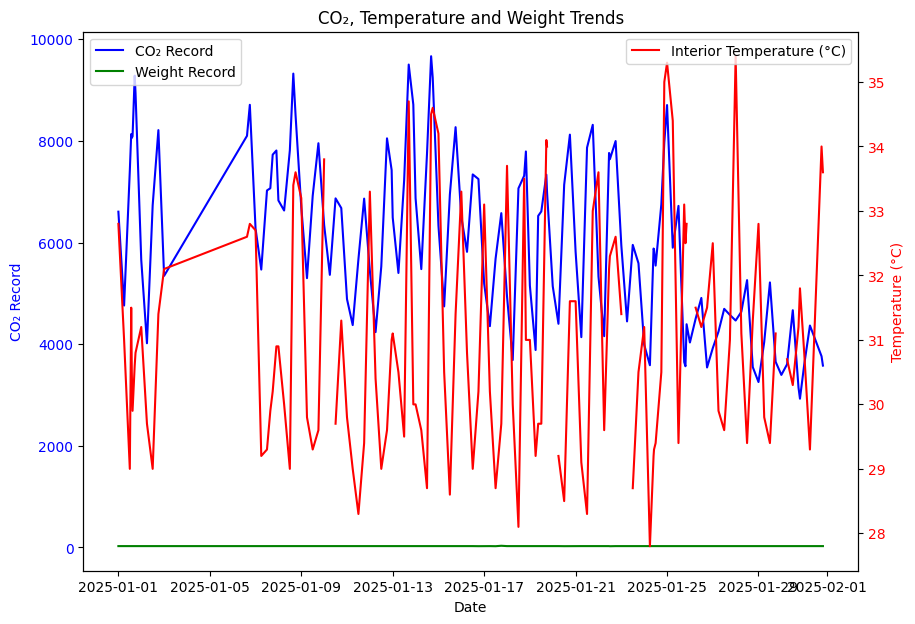

In [168]:
def main(df_co2, df_weight, df_temperature, df_humidity, year, month):
    # Execute pipelines
    co2_results = analyze_co2_pipeline(df_co2, year, month)
    weight_results = analyze_weight_for_month_year(df_weight, year, month)
    temperature_results = analyze_temperature_for_month_year(df_temperature, year, month)
    humidity_results = analyze_humidity_for_month_year(df_humidity, df_weight, df_temperature, year, month)
    correlation_results = analyze_correlations(df_humidity, df_temperature, df_weight, df_co2, year, month)

    # Collect results
    results = {
        "CO₂ Analysis": co2_results,
        "Weight Analysis": weight_results,
        "Temperature Analysis": temperature_results,
        "Humidity Analysis": humidity_results,
        "Correlation Analysis": correlation_results
    }

    # Collect plots
    plots = {
        "CO₂ Analysis": ["co2_monthly_trend.png", "co2_diurnal_variation.png"],
        "Weight Analysis": ["weight_monthly_trend.png"],
        "Temperature Analysis": ["temperature_trend.png"],
        "Humidity Analysis": ["humidity_trend.png"],
        "Correlation Analysis": ["combined_trends.png", "correlation_heatmap.png"]
    }

    # Generate PDF
    generate_pdf(results, plots, year, month)

    # Display the generated PDF in the notebook
    return IFrame(f"Monthly_Report_{year}_{month:02d}.pdf", width=600, height=400)

# Example usage
if __name__ == "__main__":
    year = 2025
    month = 1
    main(carbondioxide, weights, temperatures, humidity, year, month)